# 1.Data Exploration

## 1.1.Establishing a Connection

We start by importing all necessary libraries

In [101]:
from py2neo import Graph # to connect to our neo4j Graph database
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import itertools
#https://gist.github.com/DaniSancas/1d5265fc159a95ff457b940fc5046887 Cypher cheatsheet

Connect to running instance of Neo4J

In [102]:
graph_url = "http://localhost:7474/db/data"
graph = Graph(graph_url)

Test the connection by returning, for example, some of the countries in the database. 

In [103]:
test_query = """    MATCH (n:Country) 
                    WITH n.name AS Country 
                    RETURN Country
                    LIMIT 10;   """

DataFrame(graph.data(test_query))

,Country
0,Australia
1,Belgium
2,United States of America
3,Brazil
4,Canada
5,Poland
6,Germany
7,Finland
8,People's Republic of China
9,Czech Republic


For another test, let us see the number of publications over the years in the database.

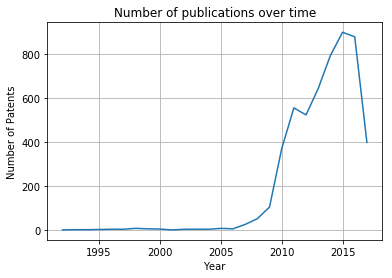

In [104]:
# query 
date_query = """ MATCH (n:PUBLICATION)
                RETURN labels(n), n.year, count(*)
                ORDER BY n.year
                """
# Extract number of publications and years, remove last entry because its "Null"
matrix = DataFrame(graph.data(date_query)).as_matrix()
dates =  matrix[:, 2][0:-1]
numbers = matrix[:, 0][0:-1]

# plot 
plt.title("Number of publications over time")
plt.xlabel("Year")
plt.ylabel("Number of Patents")
plt.plot(dates, numbers)
plt.grid()
plt.show()

## 1.2.Creating the global matrix

The goal of this part is to create a frequency matrix. As mentioned in the first meeting. 

This frequency matrix has the following items: 
* Feedstock
* Processing Tech
* Output

Furthermore, the matrix should be standardized. 

Make query

In [105]:
query = """ MATCH p1=(feed:Feedstock)<-[:CONTAINS]-(a1:Asset)-[:CONTAINS]->(proc:ProcessingTech)
            MATCH p2=(proc:ProcessingTech)<-[:CONTAINS]-(a1:Asset)-[:CONTAINS]->(out:Output) 
            WITH feed.term AS Feedstock, proc.term AS Processing_Technology, out.term AS Output, count(p1) AS count 
            RETURN Feedstock, Processing_Technology, Output, count 
            ORDER BY count
            DESC LIMIT 50""" # DESC LIMIT 300
data = DataFrame(graph.data(query)).as_matrix()

Create the axis of the matrix

In [106]:
feedstock = set(list(data[:, 0]))
processing_technology = set(list(data[:, 1]))
output = set(list(data[:, 2]))

matrix_axis = list(feedstock) + list(processing_technology) + list(output)

Build Matrix 

In [107]:
# initialize matrix
matrix = np.zeros([len(matrix_axis), len(matrix_axis)])

# find index of element in a given list
def find_index(element, in_list):
    return in_list.index(element)

# for every row in original response
for row in data:
    # the last column is the frequency
    frequency = row[-1]
    indexes = [find_index(element, matrix_axis) for element in row[0:-1]]
    # add frequency value to matrix position
    for pair in itertools.combinations(indexes, 2):
        matrix[pair[0], pair[1]] += frequency
        matrix[pair[1], pair[0]] += frequency

Let us normalize and visualize the matrix as a heatmap

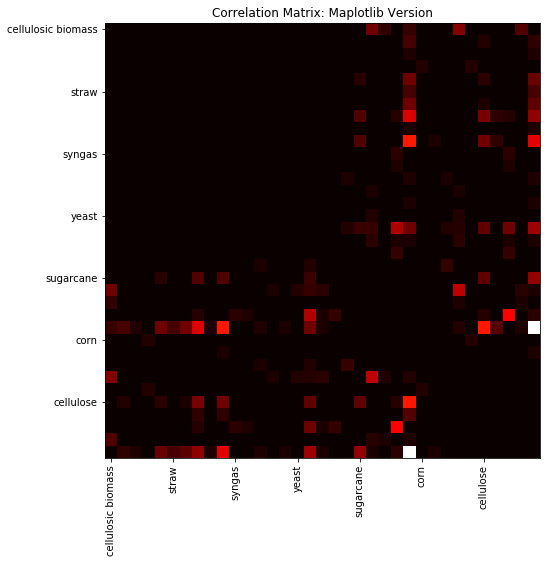

In [108]:
# normalize matrix using scipy normalization available here: http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization
normalized_matrix = (matrix - np.mean(matrix)) / np.std(matrix)

# plot a heatmap of the matrix
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(normalized_matrix, cmap='hot', interpolation='none') # plt.cm.Reds # normalization affects simmetry. 
ax.set_xticklabels(matrix_axis)
ax.set_yticklabels(matrix_axis)
plt.title("Correlation Matrix: Maplotlib Version")
plt.xticks(rotation=90) 
plt.show()

Let us see if seaborn can make this prettier. 

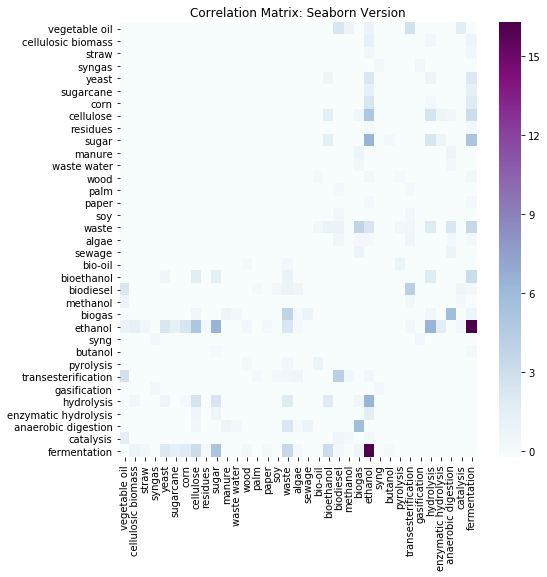

In [109]:
import seaborn as sns

# plot a heatmap of the matrix
fig, ax = plt.subplots(figsize=(8,8))
r = sns.heatmap(normalized_matrix, cmap='BuPu')
ax.set_xticklabels(matrix_axis)
ax.set_yticklabels(matrix_axis)
plt.title("Correlation Matrix: Seaborn Version")
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.show()

The matrix is symmetrical as expected. With empty squares in the middle as expected. 

## 1.3. How does the matrix change from country to country? 

In this part of the exploration we will try to compare the "frequency matrix" of two countries. 

We start by creating a function that given a country, returns its correlation matrix. Here we don't limit the query because the axis have already been determined in the first plot. 

In [110]:
def get_the_matrix_from(country):
    query = """ MATCH p1=(feed:Feedstock)<-[:CONTAINS]-(a1:Asset)-[:CONTAINS]->(proc:ProcessingTech)
            MATCH p2=(proc:ProcessingTech)<-[:CONTAINS]-(a1:Asset)-[:CONTAINS]->(out:Output) 
            MATCH (a1:Asset)-[:LOCATED_IN]->(country:Country) 
            WHERE country.name = "{}" 
            WITH feed.term AS Feedstock, proc.term AS Processing_Technology, out.term AS Output, count(p1) AS count 
            RETURN Feedstock, Processing_Technology, Output, count 
            ORDER BY count """.format(country)
    
    data = DataFrame(graph.data(query)).as_matrix()

    
    # initialize matrix
    matrix = np.zeros([len(matrix_axis), len(matrix_axis)])

    # for every row in original response
    for row in data:
        # the last column is the frequency
        frequency = row[-1]
        indexes = [find_index(element, matrix_axis) for element in row[0:-1] if element in matrix_axis]
        for pair in itertools.combinations(indexes, 2):
            matrix[pair[0], pair[1]] += frequency
            matrix[pair[1], pair[0]] += frequency
        
    
    # normalize matrix using scipy normalization available here: http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization
    normalized_matrix = normalized_matrix = (matrix - np.mean(matrix)) / np.std(matrix)
    
    return normalized_matrix

After definning the function, we apply it to two countries. 

In [111]:
country1 = 'United States of America'
country2 = 'Brazil'
country3 = 'Denmark'
country4 = 'Norway'

country1_matrix = get_the_matrix_from(country1)
country2_matrix = get_the_matrix_from(country2)
country3_matrix = get_the_matrix_from(country3)
country4_matrix = get_the_matrix_from(country4)

After applying the function to the countries, the results are plotted. 

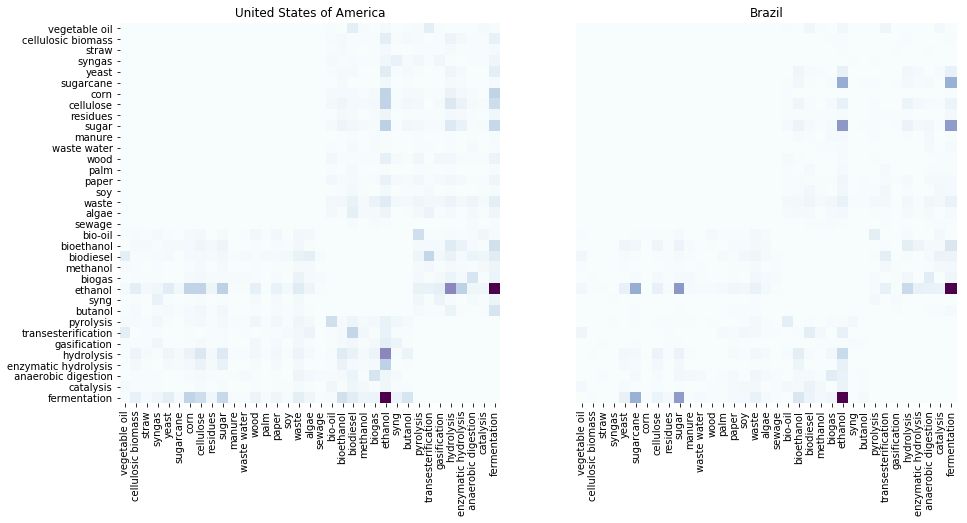

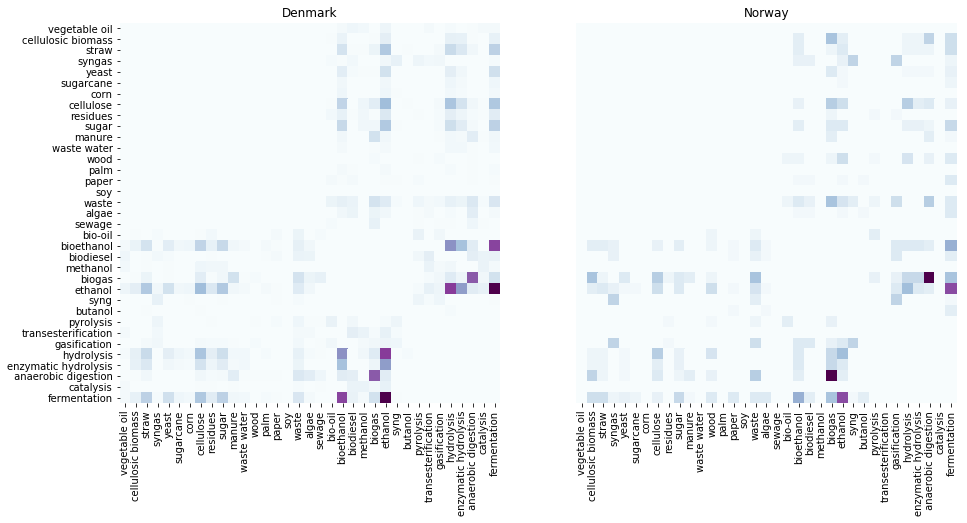

In [112]:
# first row
plt.subplots(2,1,figsize=(15,15))

plt.subplot(121)
sns.heatmap(country1_matrix, cmap='BuPu', cbar=None, square=True, xticklabels=matrix_axis, yticklabels=matrix_axis)
plt.title('{}'.format(country1))

plt.subplot(122)
sns.heatmap(country2_matrix, cmap='BuPu', cbar=None, square=True, xticklabels=matrix_axis, yticklabels=False)
plt.title('{}'.format(country2))
plt.show()

#second row
plt.subplots(2,1,figsize=(15,15))

plt.subplot(121)
sns.heatmap(country3_matrix, cmap='BuPu', cbar=None, square=True, xticklabels=matrix_axis, yticklabels=matrix_axis)
plt.title('{}'.format(country3))

plt.subplot(122)
sns.heatmap(country4_matrix, cmap='BuPu', cbar=None, square=True, xticklabels=matrix_axis, yticklabels=False)
plt.title('{}'.format(country4))
plt.show()

> Severall differences can be noted in this plot: 
> * When comparing the USA and Brazil, the USA has a bigger focus on using hydrolisis for attaining hydrolysis. 
> * Brazil and norway appear to have a rather well distributed capability. 
> * Norway and Denmark are less well distributed with a big focus on certain outputs. 

## 1.4. How does the matrix change over time? 

After seeying how to matrix changes from country to country, it's also interesting to see how it changes from year to year. For example, is the country so focused on certain flows every year? 

We start by creating a function that takes two dates and returns the frequency above, reutilizing much of the code. Here we don't limit the query because the axis have already been determined in the first plot.  

In [113]:
def get_the_matrix_from_dates(begin_date, end_date):
    query = """ MATCH p1=(feed:Feedstock)<-[:CONTAINS]-(a1:Asset)-[:CONTAINS]->(proc:ProcessingTech)
                MATCH p2=(proc:ProcessingTech)<-[:CONTAINS]-(a1:Asset)-[:CONTAINS]->(out:Output) 
                WHERE (toInteger(a1.year)<={} AND toInteger(a1.year)>={}) 
                WITH feed.term AS Feedstock, proc.term AS Processing_Technology, out.term AS Output, count(p1) AS count 
                RETURN Feedstock, Processing_Technology, Output, count 
                ORDER BY count """.format(end_date, begin_date)
    
    data = DataFrame(graph.data(query)).as_matrix()

    
    # initialize matrix
    matrix = np.zeros([len(matrix_axis), len(matrix_axis)])

    # for every row in original response
    for row in data:
        # the last column is the frequency
        frequency = row[-1]
        indexes = [find_index(element, matrix_axis) for element in row[0:-1] if element in matrix_axis]
        for pair in itertools.combinations(indexes, 2):
            matrix[pair[0], pair[1]] += frequency
            matrix[pair[1], pair[0]] += frequency
        
    
    # normalize matrix using scipy normalization available here: http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization
    normalized_matrix = normalized_matrix = (matrix - np.mean(matrix)) / np.std(matrix)
    
    return normalized_matrix

Now, we apply to two different time intervals, here choosen "randomly"

In [114]:
first_interval = [1990, 2005]
second_interval = [2006, 2019]

first_interval_matrix = get_the_matrix_from_dates(first_interval[0], first_interval[1])
second_interval_matrix = get_the_matrix_from_dates(second_interval[0], second_interval[1])

We plot the two frquency matrixes corresponding to each time interval. 

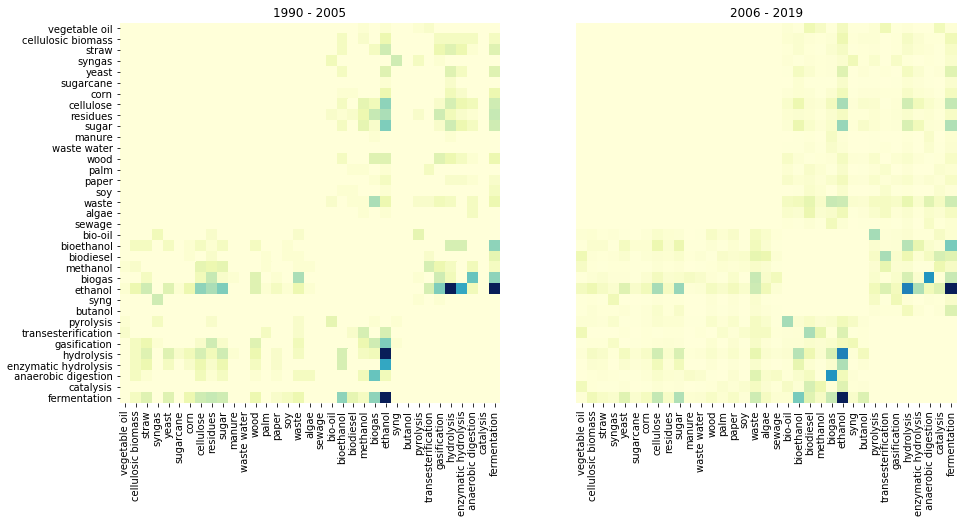

In [115]:
# first row
plt.subplots(2,1,figsize=(15,15))

plt.subplot(121)
sns.heatmap(first_interval_matrix, cmap='YlGnBu', cbar=None, square=True, xticklabels=matrix_axis, yticklabels=matrix_axis)
plt.title('{} - {}'.format(first_interval[0], first_interval[1]))

plt.subplot(122)
sns.heatmap(second_interval_matrix, cmap='YlGnBu', cbar=None, square=True, xticklabels=matrix_axis, yticklabels=False)
plt.title('{} - {}'.format(second_interval[0], second_interval[1]))
plt.show()

> Here, there seem to be some divergences when comparing: 
> * For example, in the first older interval, the output enzymatic hydrolisis seems to be more importnat than in the more recent interval. 
> * At the same time, in the more recent interval, there seem to be more concentration. 

### 1.4.1. Comparing years

Another interesting measure is to understand if a particular year has divergences when compared to other years. For this, let's take a look at the year of 2016. Since most of the code is reused, there's not much to explain here. 

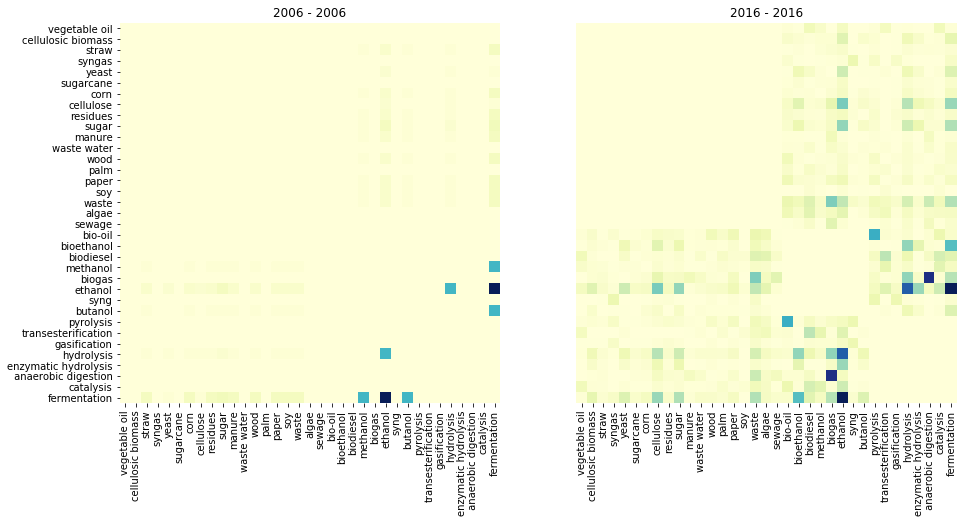

In [116]:
# set intervals
first_interval = [2006, 2006]
second_interval = [2016, 2016]

first_interval_matrix = get_the_matrix_from_dates(first_interval[0], first_interval[1])
second_interval_matrix = get_the_matrix_from_dates(second_interval[0], second_interval[1])

# first row
plt.subplots(2,1,figsize=(15,15))

# if you only want to plot half
#mask = np.zeros_like(first_interval_matrix)
#mask[np.triu_indices_from(mask)] = True
# add to heatmap, property mask=mask


plt.subplot(121)
sns.heatmap(first_interval_matrix, cmap='YlGnBu', cbar=None, square=True, xticklabels=matrix_axis, yticklabels=matrix_axis)
plt.title('{} - {}'.format(first_interval[0], first_interval[1]))

plt.subplot(122)
sns.heatmap(second_interval_matrix, cmap='YlGnBu', cbar=None, square=True, xticklabels=matrix_axis, yticklabels=False)
plt.title('{} - {}'.format(second_interval[0], second_interval[1]))
plt.show()

## 1.5.Network Properties

In this part of the exploration, we will take the first matrix that was extracted, (the non normalized, global, and absolute), and transform it into a network. Let's see what type of properties we get. 

We start by importing networkX and transforming the adjency matrix into an undirected graph. 

In [227]:
import networkx as nx
# convert matrix to graph
G = nx.to_networkx_graph(matrix) # we cant use the normalized because we want an adjency matrix. 

We then rename the nodes. 

In [228]:
# create a dictionnary to relabel nodes from numbers to asset name. (system req.)
relabel_map = {}

# for every number
for number in G.nodes():
    # the name is the position in the matrix_axis list. 
    relabel_map[number] = matrix_axis[number]

# use the dictionnary to relabel. 
nx.relabel_nodes(G, relabel_map, copy=False)

We color the nodes according to their properties (feedstock, processing technology, output). And we draw the graph

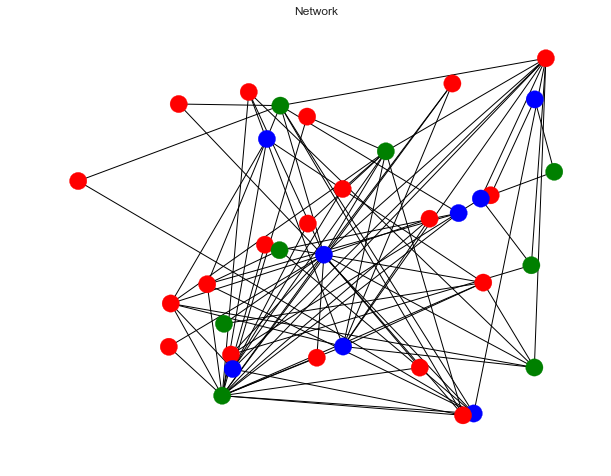

In [229]:
# create a list of colors, these are related to each node. 
color_map = []
for node in G:
    if node in feedstock: # if node is in this category
        color_map.append('red') # add to list a color specific to the category
    if node in processing_technology:
        color_map.append('green')
    if node in output:
        color_map.append('blue')
    
# plot the network using a random style 
plt.figure(figsize=(8,6));
nx.draw_random(G, node_color = color_map, style='solid')
plt.title('Network')
plt.show()

We then extract some basic properties. 

In [234]:
# create a function that takes a graph and a name, and outputs properties of that same graph. 
def network_prop(network, name):
    print '------------------------------------------------------------------------'
    average_degree = sum([network.degree()[element] for element in network.degree()]) / len([network.degree()[element] for element in network.degree()])
    print 'These are the properties of network {}:'.format(name)
    print 'The graph has {} nodes and {} edges.'.format(len(network.nodes()), len(network.edges()))  
    print 'The average node degree: ', average_degree
    print 'Less connected node: ', min(network.degree(), key=network.degree().get)
    print 'Most connecte node: ', max(network.degree(), key=network.degree().get)
    print 'Average clustering coefficient: ', (nx.average_clustering(network))
    print 'Average node connectivity: ', nx.average_node_connectivity(network)
    print '------------------------------------------------------------------------'
    
network_prop(G, 'General')
    

------------------------------------------------------------------------
These are the properties of network General:
The graph has 35 nodes and 86 edges.
The average node degree:  4
Less connected node:  straw
Most connecte node:  ethanol
Average clustering coefficient:  0.654545818327
Average node connectivity:  2.30588235294
------------------------------------------------------------------------


## 1.6.Patents over time

Another interesting observation is the number of patents over time, by country. 

We start by making a call to the Neo4j databse into a dataframe

In [231]:
# query neo4j
patent_query = """  MATCH(n:PATENT)
                    RETURN n.country, n.year, count(n)
                    ORDER BY n.country"""

# convert to dataframe
patent_data = DataFrame(graph.data(patent_query)).as_matrix()

# a list of the years and a list of countries
years = range(int(np.amin(patent_data[:,2])), int(np.amax(patent_data[:,2])))
countries = list(set(patent_data[:, 1]))

Create a dictionnary where each key is the name of a country and each value is a list with the number of patents in each year. 

In [235]:
patent_dict = {}

for country in countries:
    per_year = []
    for year in years:
        found = 0
        for i in range(patent_data.shape[0]): 
            if patent_data[i, :][1] == country and int(patent_data[i, :][2]) == year:
                per_year.append(int(patent_data[i, :][0]))
                found = 1
        if found == 0:
            per_year.append(0)
    patent_dict[country] = per_year

Finally, we can plot the distribution 

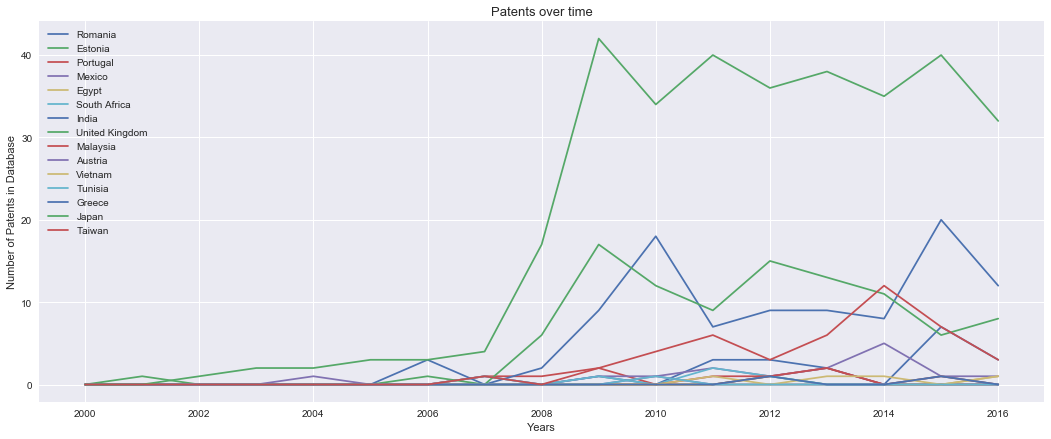

In [237]:
# variables to handle. 
countries_excluded = ['Null']
number_of_countries = 16
years_to_plot = 17
fig_width = 18
fig_height = 7

# plot
fig=plt.figure(figsize=(fig_width, fig_height))
plt.style.use('seaborn')
plt.title('Patents over time', fontsize=13)
plt.xlabel('Years')
plt.ylabel('Number of Patents in Database')
for country in patent_dict.keys()[-number_of_countries:]:
    if country in countries_excluded:
        continue
    else: 
        plt.plot(years[-years_to_plot:], patent_dict[country][-years_to_plot:], label=country)

plt.legend()
plt.show()